

### Capstone II : Bitcoin (BTC) trends and the lunar tidal rhythm of mother earth

##### Deserælle Lesdøfemmejh


##### this project will focus on the value of Bitcoin in USD as the target variable, and will construct a model using the following feature set:
* focusing in on bitcoin data only , with only outside data coming from calculated 'lunar phase'. all others will be interaction variables and or lag variables
        * one-week differential, as measure of "momentum/energy" of the day
            * consisting of sum of differences between close & open variables through the past week
        * lunar phase, 0-29 with 0 being new moon and 15 being full moon
        * moonphase x differential interaction variable
        * BTC Volume
        * Lag variables:
            * Pull from Close value offset by 2 weeks and find appropriate number of features to keep from this
* make the test set the last 2 weeks of the dataset, which will end up being 11/11/2017 - 11/24/2017  

data from Data.World -- crypto currencies from 2013-2017 
https://data.world/og5136/cryptocurrency-price-data-2013-2018

Conway_moon_calc
from http://ben-daglish.net/moon.shtml




In [ ]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

In [ ]:
import warnings

warnings.filterwarnings("ignore")

<IPython.core.display.Javascript object>

In [ ]:
## ========================================================================
## Dæyvahj Lesdøfemmejh
##  02 / 22 / 2021
## Thinkful DSI Cohort 8
## Capstone II :
##    bitcoin trends and the lunar tidal rhythm of mother earth
## ========================================================================

%reload_ext nb_black

import warnings

# package of data science helper functions written by Taylor M
from ds_functions_pkg import functions_pkg as dsf

# the basics
import pandas as pd
import numpy as np
import math

# data cleaning // outlier detection // etc
from scipy.stats import zscore
from scipy.stats.mstats import winsorize
from sqlalchemy import create_engine

# ML
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import normalize
from sklearn.preprocessing import scale
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn import linear_model
from sklearn import neighbors
from sklearn import ensemble
from sklearn.svm import SVR
from sklearn.svm import LinearSVR


# stats
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
from scipy.stats import boxcox  # for normalizing data
from scipy.stats import jarque_bera  # testing normality
from scipy.stats import normaltest  # testing normality
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse

# plotting
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import seaborn as sns
import statsmodels.api as sm

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
df = pd.read_excel("allcurrenciesfinal.xlsx")
# not that many NAs, can drop them for this project
df = df.dropna()

# only using bitcoin for this project
df = df[df["Currencyname"] == "bitcoin"]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
df.head()

,Currencyname,Date,MarketCap,Close,Open,High,Low,Volume
53546,bitcoin,2013-12-27,9.295570e+09,735.07,763.28,777.51,713.60,46862700.0
53547,bitcoin,2013-12-28,8.990850e+09,727.83,737.98,747.06,705.35,32505800.0
53548,bitcoin,2013-12-29,8.872600e+09,745.05,728.05,748.61,714.44,19011300.0
53549,bitcoin,2013-12-30,9.037000e+09,756.13,741.35,766.60,740.24,20707700.0
53550,bitcoin,2013-12-31,9.268240e+09,754.01,760.32,760.58,738.17,20897300.0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
df.describe()

,MarketCap,Close,Open,High,Low,Volume
count,1.429000e+03,1429.000000,1429.000000,1429.000000,1429.000000,1.429000e+03
mean,1.570276e+10,1003.241484,998.019090,1026.849860,972.860525,3.294848e+08
std,2.279419e+10,1369.302524,1355.486306,1406.869325,1315.890083,7.729811e+08
min,2.427830e+09,178.100000,176.900000,211.730000,171.510000,2.857830e+06
25%,4.820850e+09,350.850000,351.360000,358.630000,343.930000,2.190540e+07
50%,7.114740e+09,531.390000,531.110000,544.350000,520.080000,5.073020e+07
75%,1.213480e+10,825.370000,824.080000,841.490000,806.050000,1.304960e+08
max,1.374440e+11,8253.690000,8232.380000,8374.160000,8075.470000,8.957350e+09


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 Simple algorithm to calculate moon phase
 
 They all return a single value - the phase day (0 to 29, where 0=new moon, 15=full etc.) 


In [ ]:
def Conway_moon_calc(year, month, day):
    r = (year % 100) % 19
    if r > 9:
        r -= 19
    r = ((r * 11) % 30) + month + day
    if month < 3:
        r += 2
    r -= 4 if (year < 2000) else 8.3
    r = int(r + 0.5) % 30
    return r + 30 if r < 0 else r

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Initial cleaning steps -- parse 'Date' into day, month, year columns

In [ ]:
daylist = []
monthlist = []
yearlist = []
moonphaselist = []

for r in range(0, df.shape[0]):
    d = df["Date"].iloc[r].day
    m = df["Date"].iloc[r].month
    y = df["Date"].iloc[r].year
    daylist.append(d)
    monthlist.append(m)
    yearlist.append(y)
    moonphaselist.append(Conway_moon_calc(y, m, d))

df["day"] = daylist
df["month"] = monthlist
df["year"] = yearlist
df["moonphase"] = moonphaselist

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# compute differential between close & open value
differential_list = []
for b in range(0, df.shape[0]):
    differential_list.append(df["Close"].iloc[b] - df["Open"].iloc[b])

df["differential"] = differential_list

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

curious about the sum of the signed differentials for the week leading up to each moon phase...

In [ ]:
# compute differential between close & open value
oneweek_differential_list = [0, 0, 0, 0, 0, 0]
for b in range(6, df.shape[0]):
    diff_sum = 0
    for w in range(1, 7):
        diff_sum += df["Close"].iloc[b - w] - df["Open"].iloc[b - w]
    oneweek_differential_list.append(diff_sum)
df["one_week_diff_sum"] = oneweek_differential_list

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

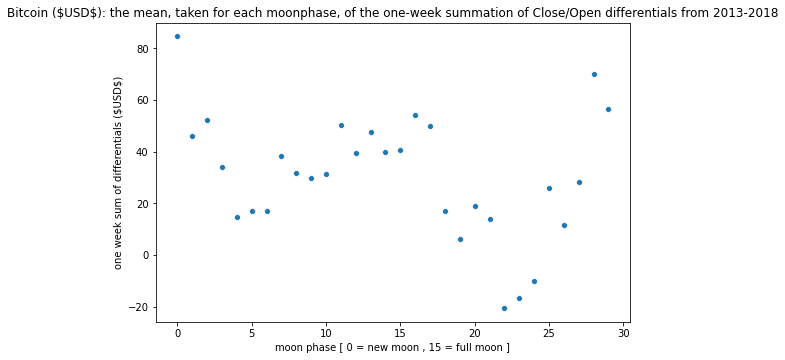

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
means_by_mp_df = df.groupby('moonphase').mean()
moonphases = means_by_mp_df.index
sns.scatterplot(x=df.groupby('moonphase').mean().index, y=means_by_mp_df['one_week_diff_sum'])
plt.title('Bitcoin (\$USD\$): the mean, taken for each moonphase, of the one-week summation of Close/Open differentials from 2013-2018')
plt.xlabel('moon phase [ 0 = new moon , 15 = full moon ]')
plt.ylabel('one week sum of differentials (\$USD\$)')

fig = plt.gcf()
fig.set_size_inches(8.5, 5.5)
fig.savefig("BTC_Moonphase_Plot.png", dpi=100)

plt.show()


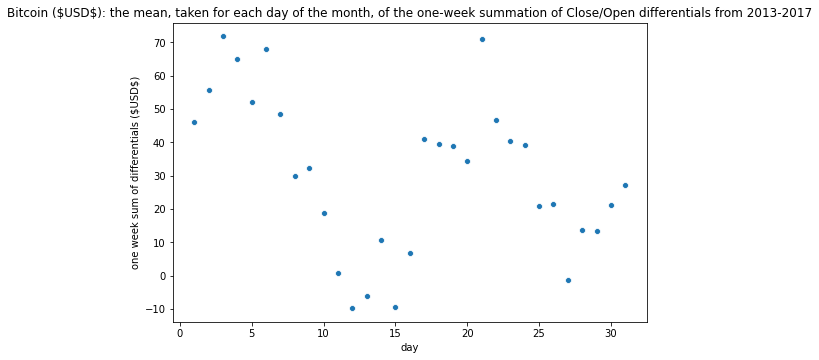

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
means_by_day_df = df.groupby("day").mean()
moonphases = means_by_mp_df.index
sns.scatterplot(
    x=df.groupby("day").mean().index, y=means_by_day_df["one_week_diff_sum"]
)
plt.title(
    "Bitcoin (\$USD\$): the mean, taken for each day of the month, of the one-week summation of Close/Open differentials from 2013-2017"
)
plt.xlabel("day")
plt.ylabel("one week sum of differentials (\$USD\$)")

fig = plt.gcf()
fig.set_size_inches(8.5, 5.5)
fig.savefig("BTC_day_mean_plot.png", dpi=100)

plt.show()

this is very interesting- apparently there are local maximums centered around the full moon & new moon, with the global maximum by far right on the new moon. in addition, there is a global minimum on the 22nd, exactly a week leading up to the new moon. 
definitely want to add interaction term with moonphase

In the 'day of the month' plot , the trends revolve around the 1st and the 15th for the most part , as expected, but there's also some definite weekly cyclical pattern going on as well. 


Check assumptions of OLS:

A1. The linear regression model is “linear in parameters.” 
--> yes

A2. There is a random sampling of observations.
--> yes

A3. The conditional mean should be zero.
--> yes

A4. There is no multi-collinearity (or perfect collinearity).
--> yes after removing problematic features

A5. Spherical errors: There is homoscedasticity and no autocorrelation --> yes

A6: Optional Assumption: Error terms should be normally distributed --> yes

### Feature Engineering 

Below are all of the features which were explored to arrive at the final chosen OLS model. Here we will discuss some of the notable discoveries in the feature engineering process:

moonphase
Unfortunately, the main variable of interest for our project, the 'moonphase' variable, wound up being less useful in the OLS model than the 'day' variable. After some exploration, it was dropped in favor of 'day' , which resulted in a lower p score and better captured the cyclical nature of the data, given that we are working with financial variables, after all. 

Lag variables
The lag variables were first offset by 2 weeks to account for the gap for our testing data. Initially we worked with 8 variables, but due to high collinearity between them we gradually cut down to 3. 

Interaction variable & BTC Volume variable
Both the interaction variable and the BTC volume variable wound up being pretty useless to our OLS models and were dropped. 

In [ ]:
# moonphase_x_diff_sum = df.moonphase * df.one_week_diff_sum

analysis_df = pd.DataFrame()

analysis_df["bitcoinUSD"] = df["Close"]
# analysis_df["moonphase"] = df["moonphase"]
# analysis_df["one_week_diff_sum"] = df["one_week_diff_sum"]
# analysis_df["moonphase_x_diff_sum"] = moonphase_x_diff_sum
analysis_df["Date"] = df["Date"]

# lag variable ( time series built in frame work for variables that depend on past variables )
# pandas series .shift() method
# Lag variable : The BTC Close price was shifted by the test_period, 2 weeks, avoid "cheating"
# by including data we technically wouldn't know in the given scenario where the date is 11-11-2017.
# After this, a lag variable was included for each day of the week, and from that , 3 were selected based on the
# P-values.

analysis_df["day"] = df["day"]
test_period = 14

analysis_df["BTC_Close_Lag_1"] = analysis_df["bitcoinUSD"].shift(1 + test_period)
# analysis_df["BTC_Close_Lag_2"] = analysis_df["bitcoinUSD"].shift(2)
# analysis_df["BTC_Close_Lag_3"] = analysis_df["bitcoinUSD"].shift(3 + test_period)
analysis_df["BTC_Close_Lag_4"] = analysis_df["bitcoinUSD"].shift(4 + test_period)
# analysis_df["BTC_Close_Lag_5"] = analysis_df["bitcoinUSD"].shift(5)
# analysis_df["BTC_Close_Lag_6"] = analysis_df["bitcoinUSD"].shift(6)
analysis_df["BTC_Close_Lag_14"] = analysis_df["bitcoinUSD"].shift(14 + test_period)

# and now we can drop first 4 weeks since there is no lag data for this time period
analysis_df = analysis_df[36:]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
X = analysis_df.drop({"bitcoinUSD", "Date"}, axis=1)
y = analysis_df.bitcoinUSD

train_cap = analysis_df.shape[0] - test_period

train_dates = analysis_df["Date"][:train_cap]
test_dates = analysis_df["Date"][train_cap + 1 : train_cap + test_period + 1]

X_train = X[:train_cap]
X_test = X[train_cap + 1 : train_cap + test_period + 1]
y_train = y[:train_cap]
y_test = y[train_cap + 1 : train_cap + test_period + 1]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
X_train = sm.add_constant(X_train)
results = sm.OLS(y_train, X_train).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             bitcoinUSD   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                     8975.
Date:                Mon, 22 Feb 2021   Prob (F-statistic):               0.00
Time:                        17:58:46   Log-Likelihood:                -9487.3
No. Observations:                1379   AIC:                         1.898e+04
Df Residuals:                    1374   BIC:                         1.901e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -7.9052     14.271     -0.554      0.580     -35.900      20.090
day                 -2.1141      0.723     -2.926      0.003      -3.532      -0.697
BTC_Close_Lag_1      1.0414      0.062     16.889      0.000       0.920       1.162
BTC_Close_Lag_4      0.3087      0.072      4.315      0.000       0.168       0.449
BTC_Close_Lag_14    -0.2387      0.038     -6.305      0.000      -0.313      -0.164
==============================================================================
Omnibus:                      417.477   Durbin-Watson:                   0.159
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            16287.703
Skew:                          -0.685   Prob(JB):                         0.00
Kurtosis:                      19.781   Cond. No.                     5.17e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.17e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### ** unscaled data- coeffecifients do not necessarily indicate the magnitude, and the warning about the large condition number is simply a scaling issue. **

# Plots

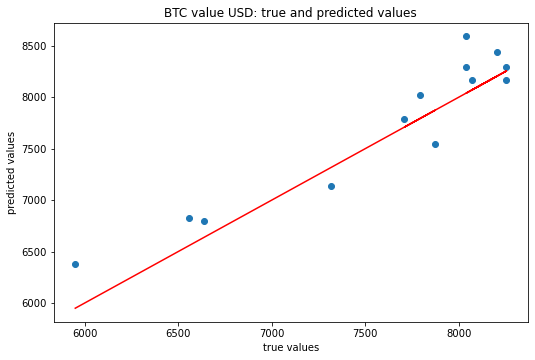

Mean absolute error of the prediction is: 224.7781033404046
Mean squared error of the prediction is: 70612.27552929589
Root mean squared error of the prediction is: 265.72970388967786
Mean absolute percentage error of the prediction is: 3.055742265001684


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
X_test = sm.add_constant(X_test)
y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")

fig = plt.gcf()
fig.set_size_inches(8.5, 5.5)
fig.savefig("BTC value true and predicted values.png", dpi=100)

plt.title("BTC value USD: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))


Plot predictions over time:

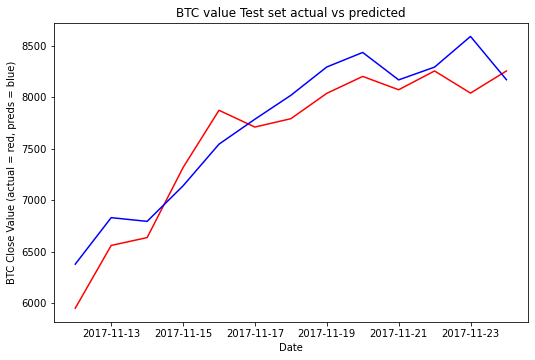

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
plt.plot(test_dates, y_test, color="red")
plt.plot(test_dates, y_preds, color="blue")
plt.title("BTC value Test set actual vs predicted")
plt.xlabel("Date")
plt.ylabel("BTC Close Value (actual = red, preds = blue)")
fig = plt.gcf()
fig.set_size_inches(8.5, 5.5)
fig.savefig("OLS_Preds.png", dpi=100)

plt.show()

# SVR Modeling Pipeline

## Hyper Parameter Tuning process

At first multiple different OLS & KNR models were tried out, with very bad results. I ran a few gridSearches with the SVR model, however these were way too computationally intense for my machine. Therefore, I used deductive reasoning and trial-and-error to narrow down to the parameters I wound up using in my SVR model, which is performing very well for our purposes. 

In [ ]:
moonphase_x_diff_sum = df.moonphase * df.one_week_diff_sum

analysis_df = pd.DataFrame()

analysis_df["bitcoinUSD"] = df["Close"]
# analysis_df["moonphase"] = df["moonphase"]
# analysis_df["one_week_diff_sum"] = df["one_week_diff_sum"]
# analysis_df["moonphase_x_diff_sum"] = moonphase_x_diff_sum
analysis_df["Date"] = df["Date"]

# lag variable ( time series built in frame work for variables that depend on past variables )
# pandas series .shift() method
# Lag variable : The BTC Close price for each day of the past week will be included !!
test_period = 14

analysis_df["day"] = df["day"]

analysis_df["BTC_Close_Lag_1"] = analysis_df["bitcoinUSD"].shift(1 + test_period)
analysis_df["BTC_Close_Lag_4"] = analysis_df["bitcoinUSD"].shift(4 + test_period)
analysis_df["BTC_Close_Lag_14"] = analysis_df["bitcoinUSD"].shift(14 + test_period)

# and now we can drop first 4 weeks since there is no lag data for this time period
analysis_df = analysis_df[36:]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
X = analysis_df.drop({"bitcoinUSD", "Date"}, axis=1)
y = analysis_df.bitcoinUSD

train_cap = analysis_df.shape[0] - test_period


train_dates = analysis_df["Date"][:train_cap]
test_dates = analysis_df["Date"][train_cap + 1 : train_cap + test_period + 1]

X_train = X[:train_cap]
X_test = X[train_cap + 1 : train_cap + test_period + 1]
y_train = y[:train_cap]
y_test = y[train_cap + 1 : train_cap + test_period + 1]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pickle

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV


from sklearn.preprocessing import StandardScaler, OneHotEncoder
from category_encoders import LeaveOneOutEncoder

# Fill out your column datatypes here
num_cols = ['BTC_Close_Lag_1', 'BTC_Close_Lag_4',
       'BTC_Close_Lag_14', 'day']

bin_cols = []

cat_cols = []
drop_cats = []

# fmt: off
preprocessing = ColumnTransformer([
    # Encode categories
    # Potentially use one of the 2 below options
    #("OneHotEncoder", OneHotEncoder(drop=drop_cats), cat_cols),
    # ('leaveoneoutencoder', LeaveOneOutEncoder(), cat_cols),

    # Scale numeric columns
    # (not needed for all models but can't hurt)
    ("scaler", StandardScaler(), num_cols)
    # bin_cols we'll leave untouch
], remainder="passthrough")


pipeline = Pipeline([
    # Apply ColumnTransformer steps
    ("preprocessing", preprocessing),

    # Add other steps as desired
    # ('dim_reduction', PCA()),
    # ('feature_selection', SelectKBest()),

    # Choose your model and put it here
    #("knn", KNeighborsRegressor(3)),]) # KNR was pretty terrible
    ("svr", SVR(kernel="linear", gamma = 1, degree = 2, C = 10000.0))])
    #("OLS", sm.OLS())])

#X_train = sm.add_constant(X_train)
pipeline.fit(X_train, y_train)


#grid = {
#     "svr__C": [10.0, 100.0, 1000.0],
#     "svr__kernel": ["linear", "rbf", "poly"],
#     "svr__gamma": [0.1, 1, 10],
#     "svr__degree": [2, 3, 4],
#}

# fmt: on

#pipeline_cv = GridSearchCV(pipeline, grid)
#pipeline_cv.fit(X_train, y_train)

print(f"Train score: {pipeline.score(X_train, y_train):.4f}")
print(f"Test score: {pipeline.score(X_test, y_test):.4f}")

# Evaluate your model using additional appropriate metrics
# If doing regression consider:
# * Mean Absolute Error
# * Mean Absolute Percent Error
# * Fitted by Actuals scatter plot

# If doing classification consider:
# * Confusion matrix
# * Classification report

# Save to file
# best_model = pipeline_cv.best_estimator_
# with open("saved_model.pkl", "wb") as f:
#     pickle.dump(best_model, f)


# # Load from file
# with open("saved_model.pkl", "rb") as f:
#     loaded_model = pickle.load(f)

# preds = loaded_model.predict(X_test)


Train score: 0.9622
Test score: 0.8912


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#
# MAE & MAPE scores
#

y_pred = pipeline.predict(X_test)

mae = np.mean(np.abs(y_pred - y_test))
mape = np.mean(np.abs((y_pred - y_test) / y_test))

# On average, we're within <MAE> of the right answer
# print(f"MAE: {mae}")
print(f"On average, we're within ${mae:.2f} of the right answer.\n")

# print(f"MAPE: {mape}")
print(f"On average, we're within {100 * mape:.2f}% of the right answer.\n")

On average, we're within $204.16 of the right answer.

On average, we're within 2.74% of the right answer.



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

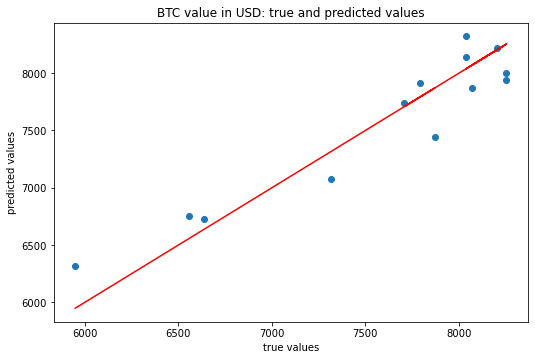

Mean absolute error of the prediction is: 204.15672797204732
Mean squared error of the prediction is: 56565.74872373416
Root mean squared error of the prediction is: 237.83554974758118
Mean absolute percentage error of the prediction is: 2.744747138677584


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#X_test = sm.add_constant(X_test)
y_preds = pipeline.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("BTC value in USD: true and predicted values")

fig = plt.gcf()
fig.set_size_inches(8.5, 5.5)
fig.savefig("BTC Forecast: True vs Predicted.png", dpi=100)

plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))


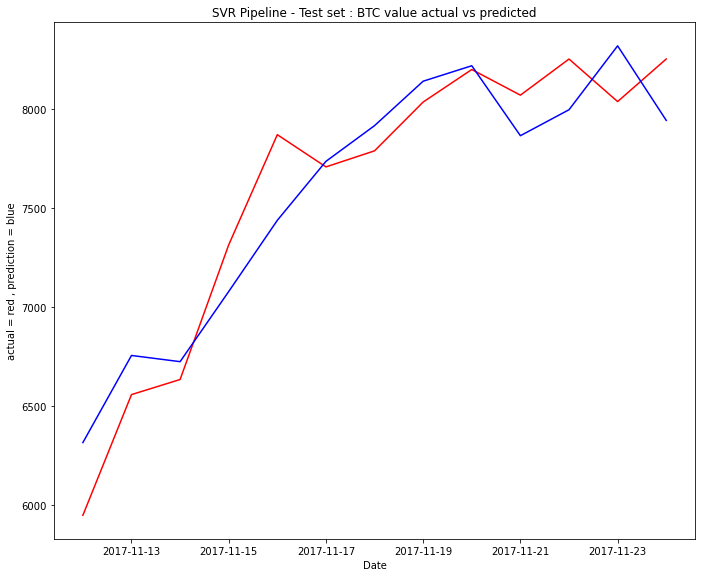

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
plt.plot(test_dates, y_test, color="red")
plt.plot(test_dates, y_preds, color="blue")
plt.title("SVR Pipeline - Test set : BTC value actual vs predicted")

plt.xlabel("Date")
plt.ylabel("actual = red , prediction = blue")

fig = plt.gcf()
fig.set_size_inches(11.5, 9.5)
fig.savefig("BTC_Pipeline_Test_vs_Actual.png", dpi=100)

plt.show()

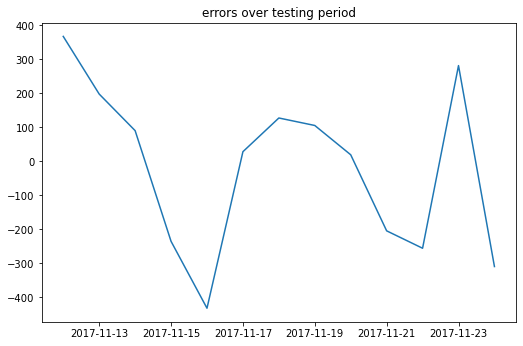

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
errors = y_pred - y_test
plt.plot(test_dates, errors)
plt.title("errors over testing period")

fig = plt.gcf()
fig.set_size_inches(8.5, 5.5)
fig.savefig("Errors over testing period.png", dpi=100)

plt.show()

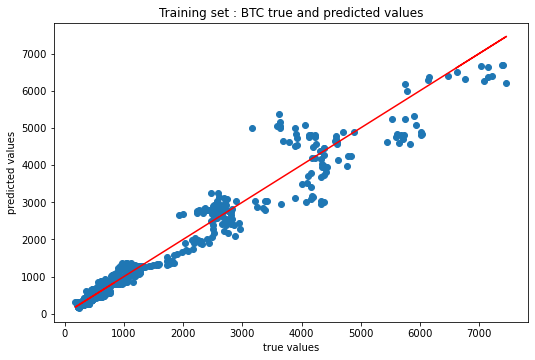

Mean absolute error of the prediction is: 204.15672797204732
Mean squared error of the prediction is: 56565.74872373416
Root mean squared error of the prediction is: 237.83554974758118
Mean absolute percentage error of the prediction is: 2.744747138677584


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#X_train = sm.add_constant(X_train)
y_training_preds = pipeline.predict(X_train)

plt.scatter(y_train, y_training_preds)
plt.plot(y_train, y_train, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Training set : BTC true and predicted values")

fig = plt.gcf()
fig.set_size_inches(8.5, 5.5)
plt.show()

fig.savefig("BTC_Pipeline_Test_vs_Actual.png", dpi=100)
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))


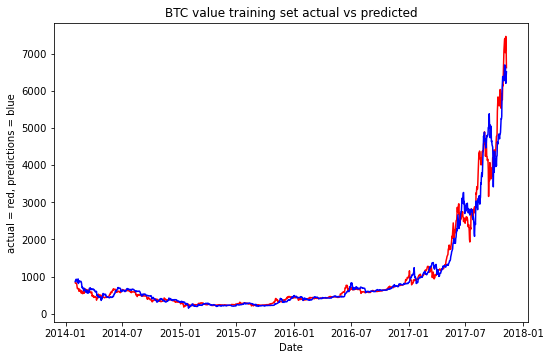

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
plt.plot(train_dates, y_train, color="red")
plt.plot(train_dates, y_training_preds, color="blue")
plt.title("BTC value training set actual vs predicted")
plt.xlabel("Date")
plt.ylabel("actual = red, predictions = blue")
fig = plt.gcf()
fig.set_size_inches(8.5, 5.5)

fig.savefig("BTC_Pipeline_Training_Preds_vs_Actual.png", dpi=100)

plt.show()

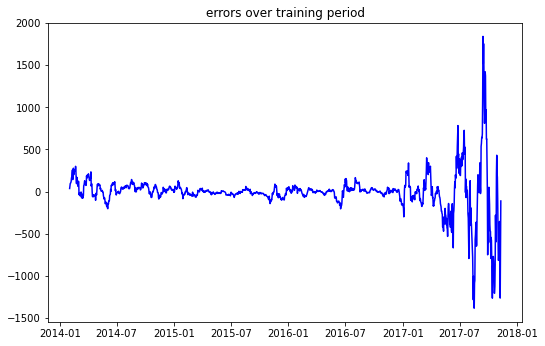

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
errors = y_training_preds - y_train
plt.plot(train_dates, errors, color="blue")
plt.title("errors over training period")

fig = plt.gcf()
fig.set_size_inches(8.5, 5.5)
fig.savefig("BTC_Pipeline_Training_Errors.png", dpi=100)

plt.show()

### Closing Summary
Both models are performing well & do a great job of accurately predicting this two week spike in the BTC price.

OLS is looking like a great model to go with because it is not over-fit like the SVR() model, and it has a faster run time which makes it ideal for further exploration.

If the testing period is expanded into multiple months, SVR() could possibly out-perform the OLS model. 
